# Visualize the model performance after using tab_err on the test set.

We run experiments on the downstream performance of ML models on both clean and errored test data.

The error models we chose were composed of the error mechanisms: EAR, ECAR, and ENAR, the wrong unit and extraneous error types, and error rates: 0.1, 0.25, 0.5, 0.75, 0.9

The criteria for choosing datasets:

- Less than 100,000 rows and 100 columns

- From the Tree Based Methods Paper

See the bit on how we compare performance later in the notebook.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


textwidth_pt = 395.8225
table_cell_width_pt = textwidth_pt/8

In [3]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # ACM uses Linux Libertine as the main font
    "text.latex.preamble": r"\usepackage{libertine}",
    # Use 9pt font in plots to match ACM style
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts slightly smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
plt.rcParams.update(tex_fonts)
sns.set_palette("deep")

In [4]:
def set_size(width, fraction=1.0, height_ratio=None):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    height_ratio: float, optional
        Scale the golden ratio by this. If None, uses the golden ratio.

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    fig_width_in = fig_width_pt * inches_per_pt

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    if height_ratio is not None:
        golden_ratio = height_ratio * golden_ratio
    fig_height_in = fig_width_in * golden_ratio
    return (fig_width_in, fig_height_in)

In [2]:
def aggregate_results(root_dir):
    """Aggregate error metric scores from result.csv files in a nested directory structure.
    
    Args:
        root_dir (str): The top-level directory path
    
    Returns:
        pd.DataFrame: Multi-indexed DataFrame with avergae scores for each (error_type, error_rate, mechanism, metric)
    """
    raw_records = []
    
    for dataset_id in os.listdir(root_dir):
        dataset_path = os.path.join(root_dir, dataset_id)
        if not os.path.join(root_dir, dataset_id):
            continue
    
        for error_rate in os.listdir(dataset_path):
            rate_path = os.path.join(dataset_path, error_rate)
            results_file = os.path.join(rate_path, 'results.csv')
            error_props_file = os.path.join(rate_path, 'error_props.csv')
            if not os.path.isfile(results_file):
                continue
    
            df = pd.read_csv(results_file)  # Rows: metric, columns: metadata/metric values
            eprop_df = pd.read_csv(error_props_file)
            
            for _, row in df.iterrows():
                for mechanism in ["ECAR", "EAR", "ENAR"]:
                    raw_records.append({
                        'error_type': os.path.basename(root_dir),
                        'dataset_id': dataset_id,
                        'error_rate': float(error_rate),
                        'mechanism': mechanism,
                        'metric': row['evaluation_metric'],
                        'score': row[mechanism] / row['clean'],
                        'actual_error_rate': eprop_df.iloc[0].mean()
                    })
            
    
    return pd.DataFrame(raw_records)


Aggregate the results from the experiment directories

In [3]:
clf_wrongunit_extraneous = aggregate_results("../results/clf-wrongunit-extraneous")

Number of classification datasets

In [4]:
len(clf_wrongunit_extraneous.groupby("dataset_id").size())

15

Range, mean and standard deviation of actual error rates vs theoretical/specified (since we may have an odd number of rows it is not always exact, i.e. what is 25% of 3?)

In [5]:
clf_wrongunit_extraneous.groupby("error_rate")["actual_error_rate"].mean()

error_rate
0.10    0.099330
0.25    0.249468
0.50    0.499577
0.75    0.749546
0.90    0.899529
Name: actual_error_rate, dtype: float64

In [6]:
clf_wrongunit_extraneous.groupby("error_rate")["actual_error_rate"].var()**(.5)


error_rate
0.10    0.000725
0.25    0.000769
0.50    0.000624
0.75    0.000683
0.90    0.000547
Name: actual_error_rate, dtype: float64

In [7]:
clf_wrongunit_extraneous.groupby("error_rate")["actual_error_rate"].min()

error_rate
0.10    0.097792
0.25    0.247059
0.50    0.498039
0.75    0.747634
0.90    0.898039
Name: actual_error_rate, dtype: float64

In [8]:
clf_wrongunit_extraneous.groupby("error_rate")["actual_error_rate"].min()

error_rate
0.10    0.097792
0.25    0.247059
0.50    0.498039
0.75    0.747634
0.90    0.898039
Name: actual_error_rate, dtype: float64

In [ ]:
# Swap order -- Done, looks better
# Color code all pts
# Averages w color coding

In [9]:
from scipy.stats import ks_2samp
import itertools

# Mechanism combinations to compare
mech_pairs = list(itertools.combinations(["ENAR", "ECAR", "EAR"], 2))

# Run KS test and store p-values
sig_results = {}

for rate, subdata in clf_wrongunit_extraneous.groupby("error_rate"):
    for mech1, mech2 in mech_pairs:
        scores1 = subdata[subdata["mechanism"] == mech1]["score"]
        scores2 = subdata[subdata["mechanism"] == mech2]["score"]
        stat, pval = ks_2samp(scores1, scores2)
        sig_results[(rate, mech1, mech2)] = pval

Boxplots of average scores over datasetids

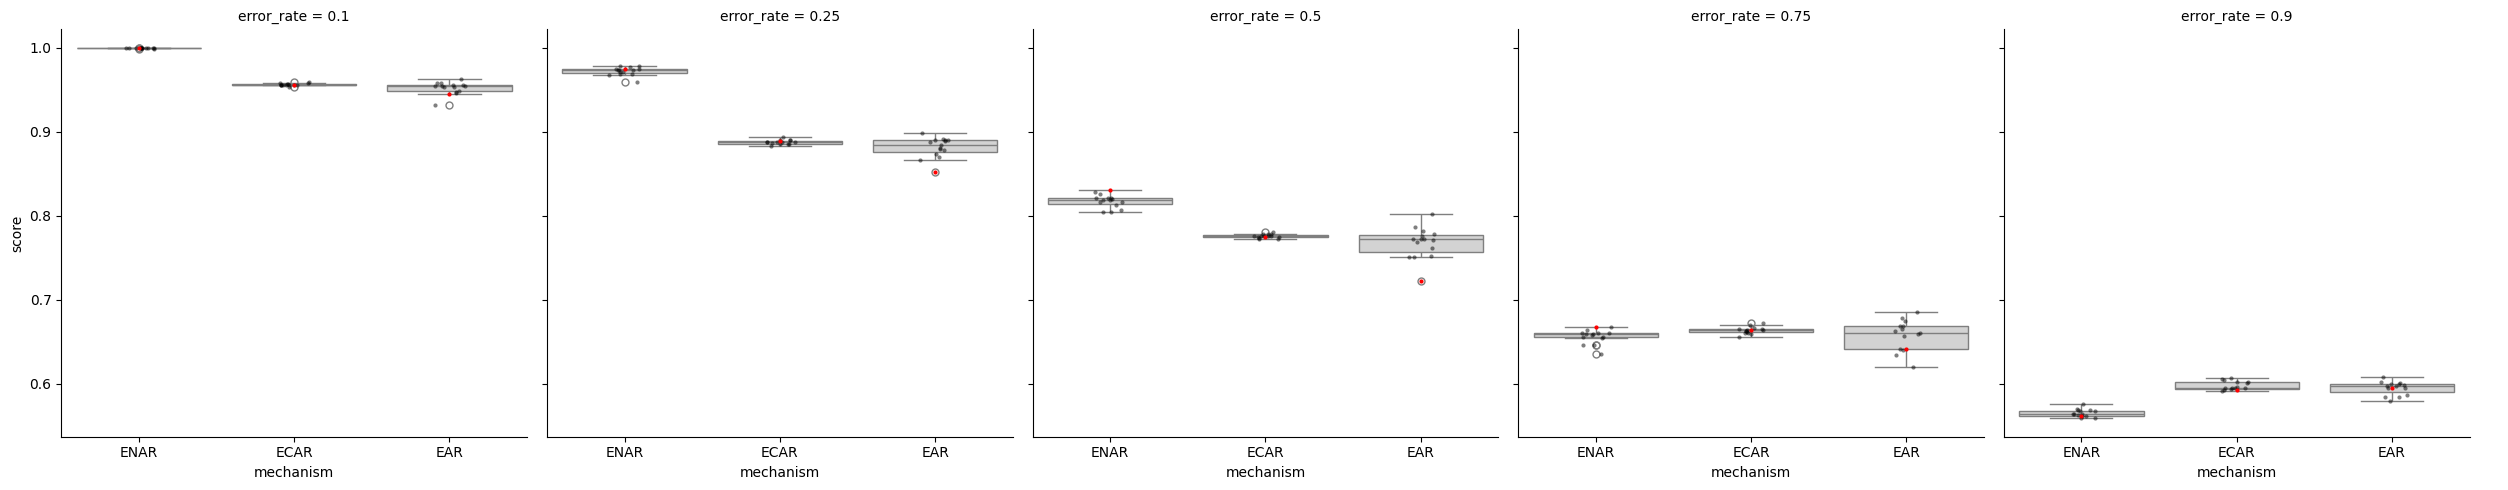

In [15]:
# Step 1: Aggregate the scores per dataset_id, mechanism, and error_rate
agg_df = (
    clf_wrongunit_extraneous
    .groupby(["dataset_id", "mechanism", "error_rate"], as_index=False)
    .agg({"score": "median"})  # Use "median" if you prefer
)

# Step 2: Create the boxplot (grouped by mechanism and error_rate)
g = sns.catplot(
    data=agg_df,
    x="mechanism",
    y="score",
    col="error_rate",
    kind="box",
    order=["ENAR", "ECAR", "EAR"],
    color='lightgray',
)

# Step 3: Overlay the aggregated strip plots
for ax, (rate, subset) in zip(g.axes.flat, agg_df.groupby("error_rate")):
    # All other dataset_ids
    sns.stripplot(
        data=subset[subset['dataset_id'] != "44162"],
        x="mechanism",
        y="score",
        order=["ENAR", "ECAR", "EAR"],
        ax=ax,
        color="black",
        jitter=True,
        alpha=0.5,
        size=3
    )

    # Highlight dataset_id == 44162
    sns.stripplot(
        data=subset[subset['dataset_id'] == "44162"],
        x="mechanism",
        y="score",
        order=["ENAR", "ECAR", "EAR"],
        ax=ax,
        color="red",
        jitter=True,
        alpha=1,
        size=3
    )

Error rate 0.25 box and strip plots

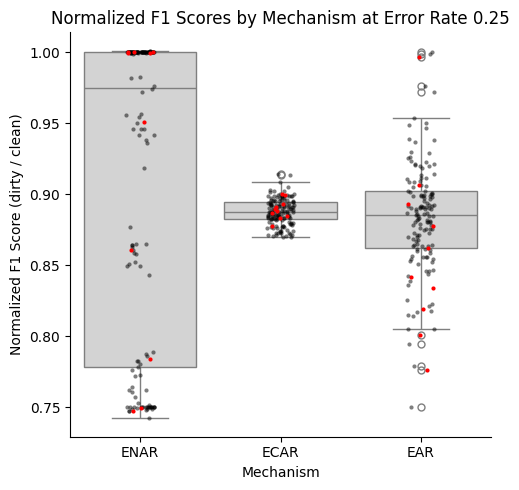

In [ ]:
# Filter only error_rate == 0.25
subset_data = clf_wrongunit_extraneous[clf_wrongunit_extraneous['error_rate'] == 0.25]

# Plot
g = sns.catplot(
    data=subset_data,
    x="mechanism",
    y="score",
    col="error_rate",  # Still keeps it as a facet if needed (will be just one column)
    kind="box",
    order=["ENAR", "ECAR", "EAR"],
    color='lightgray',
)

# You only have one subplot now, so just access it directly
ax = g.axes.flat[0]

# Plot all points except dataset_id 44162
sns.stripplot(
    data=subset_data[subset_data['dataset_id'] != "44162"],
    x="mechanism",
    y="score",
    order=["ENAR", "ECAR", "EAR"],
    ax=ax,
    color="black",
    jitter=True,
    alpha=0.5,
    size=3
)

# Highlight dataset_id 44162
sns.stripplot(
    data=subset_data[subset_data['dataset_id'] == "44162"],
    x="mechanism",
    y="score",
    order=["ENAR", "ECAR", "EAR"],
    ax=ax,
    color="red",
    jitter=True,
    alpha=1,
    size=3
)

plt.ylabel("Normalized F1 Score (dirty / clean)")
plt.xlabel("Mechanism")
plt.tight_layout()
plt.show()

Box/strip plots with 44162 highlighted (illustrative example)

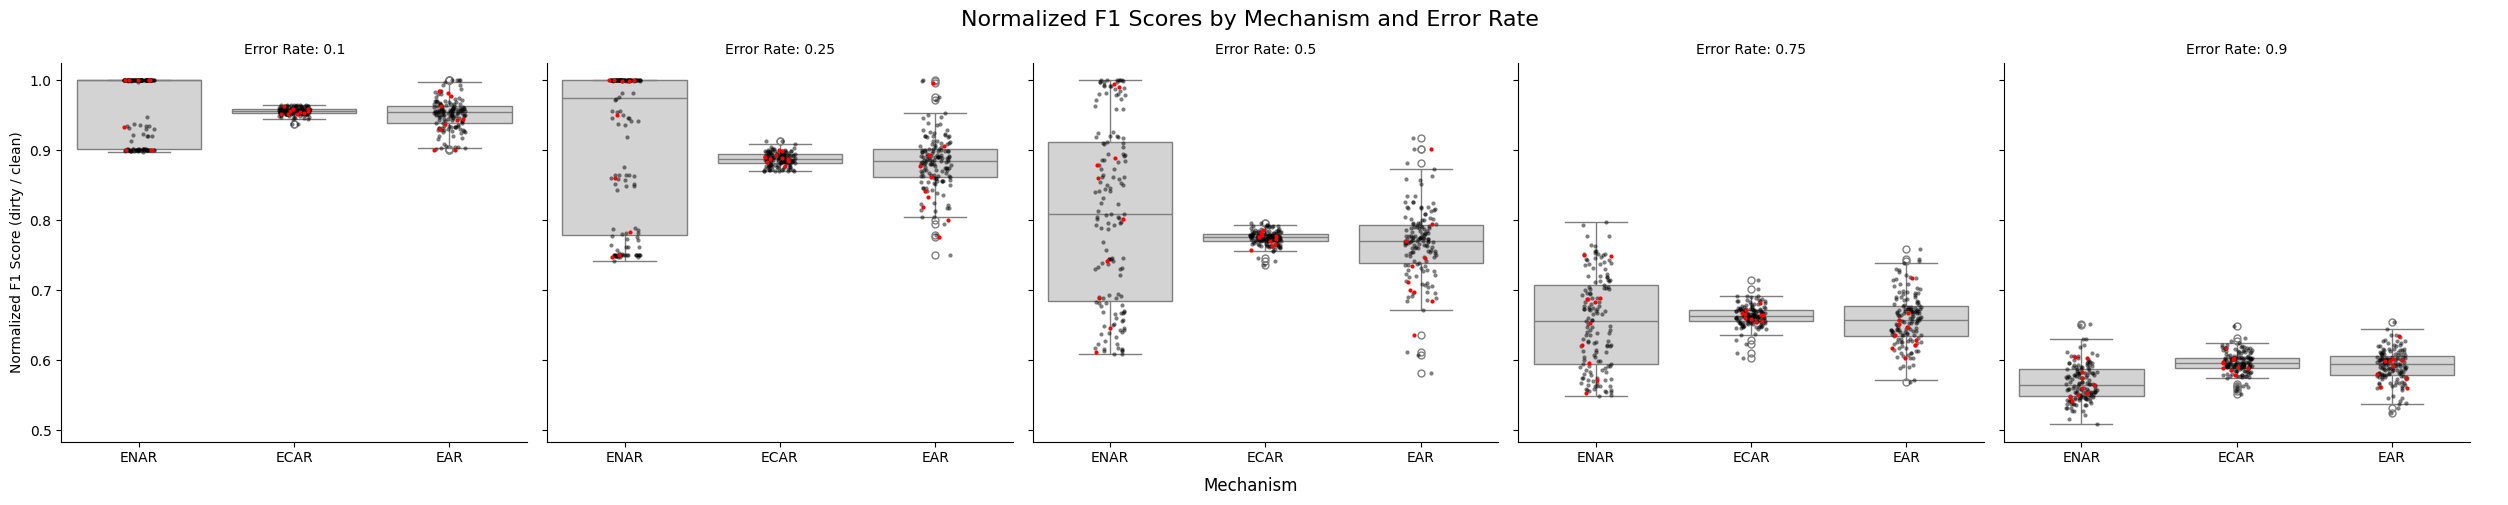

In [26]:
g = sns.catplot(
    data=clf_wrongunit_extraneous,
    x="mechanism",
    y="score",
    col="error_rate",
    kind="box",
    order=["ENAR", "ECAR", "EAR"],
    color='lightgray',
)

for ax, (rate, subset) in zip(g.axes.flat, clf_wrongunit_extraneous.groupby("error_rate")):
    # Strip plot for all other points
    sns.stripplot(
        data=subset[subset['dataset_id'] != "44162"],
        x="mechanism",
        y="score",
        order=["ENAR", "ECAR", "EAR"],
        ax=ax,
        color="black",
        jitter=True,
        alpha=0.5,
        size=3
    )

    # Strip plot for highlighted dataset_id 44162
    sns.stripplot(
        data=subset[subset['dataset_id'] == "44162"],
        x="mechanism",
        y="score",
        order=["ENAR", "ECAR", "EAR"],
        ax=ax,
        color="red",  # or any color you'd like
        jitter=True,
        alpha=1,
        size=3  # optionally larger to emphasize
    )
    ax.set_xlabel("")

g.figure.suptitle("Normalized F1 Scores by Mechanism and Error Rate", fontsize=16)

g.set_axis_labels("", "Normalized F1 Score (dirty / clean)")
g.set_titles(col_template="Error Rate: {col_name}")
g.figure.supxlabel("Mechanism", fontsize=12)
plt.subplots_adjust(top=0.875)  # Adjust the top to make room for the title
plt.show()


Violin plots of all datasets

'\n# Annotate significance\nfor ax, (rate, _) in zip(g.axes.flat, clf_wrongunit_extraneous.groupby("error_rate")):\n    ypos = ax.get_ylim()[1] * 0.95  # starting y-position for annotation\n    for i, (mech1, mech2) in enumerate(mech_pairs):\n        pval = sig_results[(rate, mech1, mech2)]\n        if pval < 0.05:\n            x1 = ["ENAR", "ECAR", "EAR"].index(mech1)\n            x2 = ["ENAR", "ECAR", "EAR"].index(mech2)\n            ax.plot([x1, x1, x2, x2], [ypos, ypos+0.01, ypos+0.01, ypos], lw=1.5, c=\'k\')\n            ax.text((x1 + x2) / 2, ypos + 0.015, f"p = {pval:.3f}", ha=\'center\', va=\'bottom\')\n            ypos += 0.05  # stack annotations vertically\n'

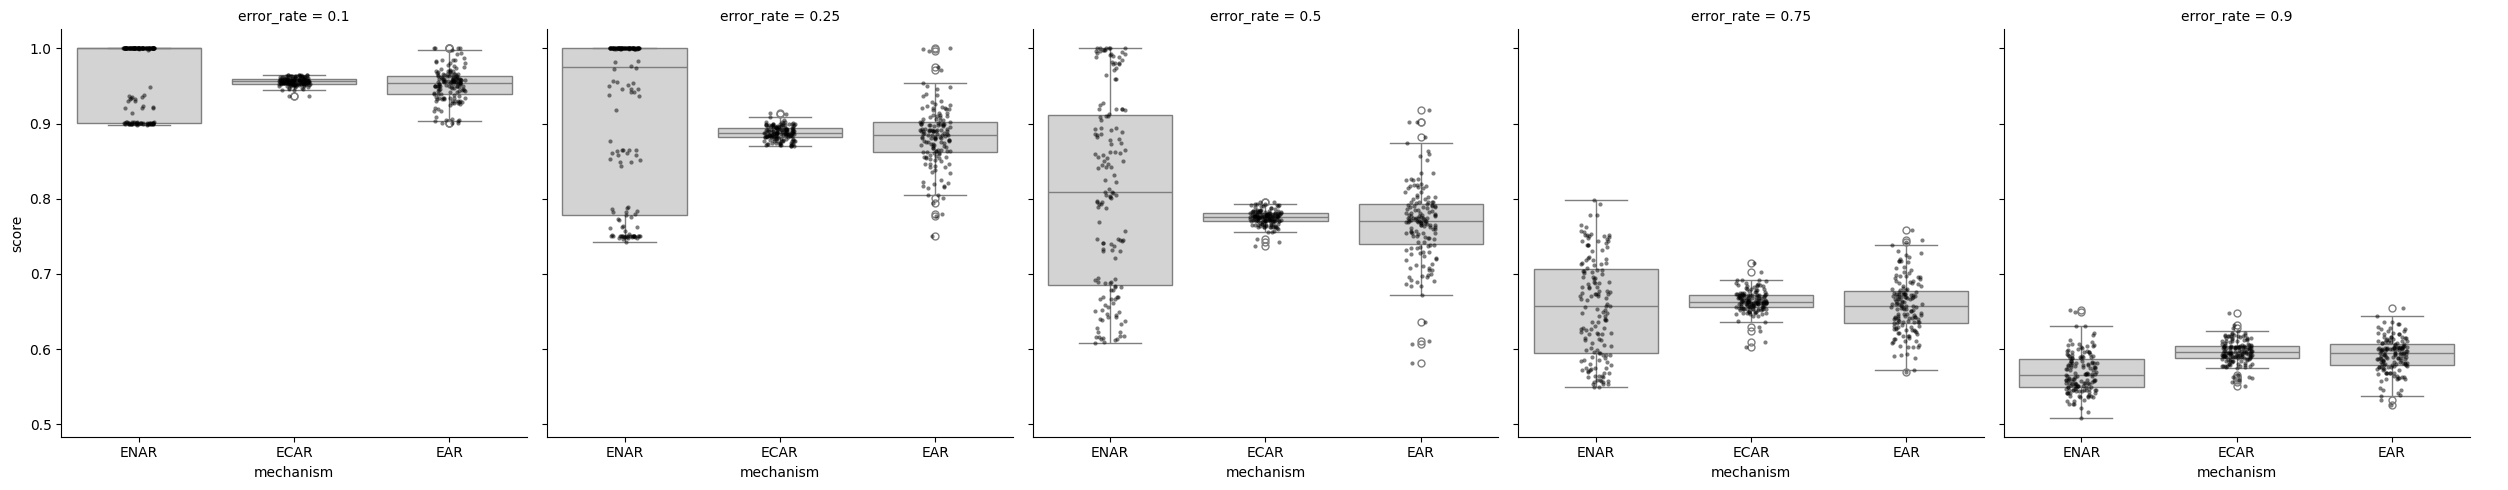

In [54]:
g = sns.catplot(
    data=clf_wrongunit_extraneous,
    x="mechanism",
    y="score",
    col="error_rate",
    kind="box",
    order=["ENAR", "ECAR", "EAR"],
    color='lightgray',
)


# Add the strip plots on top of each boxplot
for ax, (rate, subset) in zip(g.axes.flat, clf_wrongunit_extraneous.groupby("error_rate")):
    sns.stripplot(
        data=subset,
        x="mechanism",
        y="score",
        order=["ENAR", "ECAR", "EAR"],
        ax=ax,
        color="black",
        jitter=True,
        alpha=0.5,
        size=3
    )

'''
# Annotate significance
for ax, (rate, _) in zip(g.axes.flat, clf_wrongunit_extraneous.groupby("error_rate")):
    ypos = ax.get_ylim()[1] * 0.95  # starting y-position for annotation
    for i, (mech1, mech2) in enumerate(mech_pairs):
        pval = sig_results[(rate, mech1, mech2)]
        if pval < 0.05:
            x1 = ["ENAR", "ECAR", "EAR"].index(mech1)
            x2 = ["ENAR", "ECAR", "EAR"].index(mech2)
            ax.plot([x1, x1, x2, x2], [ypos, ypos+0.01, ypos+0.01, ypos], lw=1.5, c='k')
            ax.text((x1 + x2) / 2, ypos + 0.015, f"p = {pval:.3f}", ha='center', va='bottom')
            ypos += 0.05  # stack annotations vertically
'''

Violin plots of each dataset

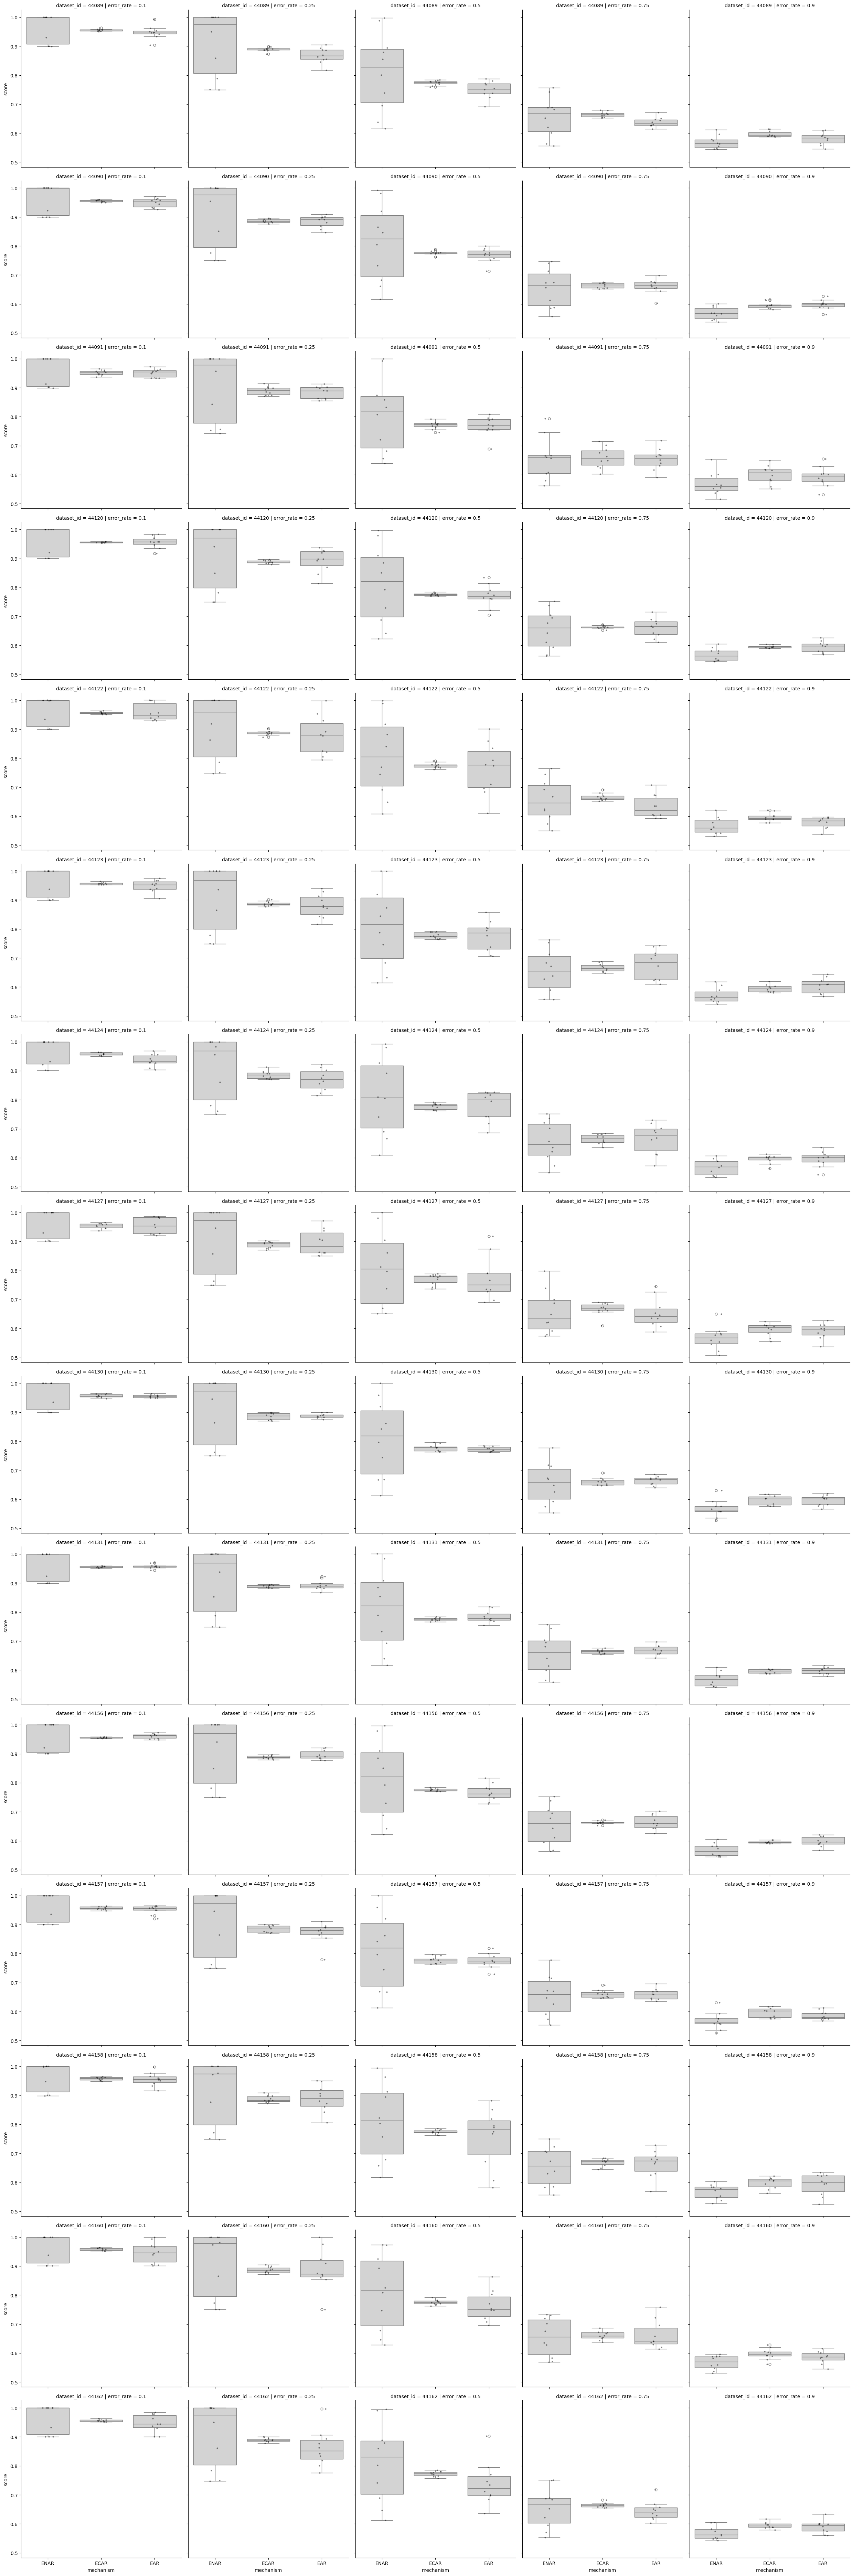

In [55]:
# Create the base catplot
g = sns.catplot(
    data=clf_wrongunit_extraneous,
    x="mechanism",
    y="score",
    col="error_rate",
    row="dataset_id",
    kind="box",
    order=["ENAR", "ECAR", "EAR"],
    color='lightgray',
)

# Iterate over the axes and correct facet combinations
group_keys = list(clf_wrongunit_extraneous.groupby(["dataset_id", "error_rate"]).groups.keys())

for ax, (dataset_id, error_rate) in zip(g.axes.flat, group_keys):
    # Filter for this facet's subset
    subset = clf_wrongunit_extraneous[
        (clf_wrongunit_extraneous["dataset_id"] == dataset_id) & 
        (clf_wrongunit_extraneous["error_rate"] == error_rate)
    ]

    # Overlay individual data points
    sns.stripplot(
        data=subset,
        x="mechanism",
        y="score",
        order=["ENAR", "ECAR", "EAR"],
        ax=ax,
        color="black",
        jitter=True,
        alpha=0.5,
        size=3
    )